<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span><ul class="toc-item"><li><span><a href="#Проверим-качество-моделей-без-учета-дисбаланса." data-toc-modified-id="Проверим-качество-моделей-без-учета-дисбаланса.-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Проверим качество моделей без учета дисбаланса.</a></span></li></ul></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span><ul class="toc-item"><li><span><a href="#Увеличение-выборки" data-toc-modified-id="Увеличение-выборки-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Увеличение выборки</a></span></li><li><span><a href="#Уменьшение-выборки" data-toc-modified-id="Уменьшение-выборки-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Уменьшение выборки</a></span></li></ul></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
from sklearn.metrics import (confusion_matrix,
                             f1_score,
                             precision_score,
                             recall_score, 
                             roc_curve,
                             roc_auc_score,
                             accuracy_score)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.dummy import DummyClassifier

In [2]:
def metrics(target_valid, predicted_valid):
    '''
    Функция для расчета метрик Полнота, Точность, F1-мера и построения матрицы ошибок
    '''
    print('Матрица ошибок:\n', confusion_matrix(target_valid, predicted_valid))
    print("Полнота:", recall_score(target_valid, predicted_valid))
    print("Точность:", precision_score(target_valid, predicted_valid))
    print("F1-мера:", f1_score(target_valid, predicted_valid))
    
    
def auc_roc(features_valid, target_valid, model, model_name):
    '''
    Функция для расчета AUC-ROC и построения ROC-кривой на графике
    '''
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name}\nROC-кривая')
    plt.show()
    auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
    print(auc_roc)
    
    
def upsample(features, target, repeat):
    '''
    Функция для увеличения выборки, чтобы редкий класс стал не таким редким.
    '''
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=RANDOM_STATE)
    
    return features_upsampled, target_upsampled

def downsample(features, target, fraction):
    '''
    Функция для уменьшения выборки, чтобы частый класс стал не таким частым.
    '''
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled


Загрузим данные из файла `/datasets/Churn.csv` в переменную `data`

In [3]:
try:
    data = pd.read_csv('Churn.csv')
except:
    data = pd.read_csv('/datasets/Churn.csv')

Изучим данные

In [4]:
display(data.head())
display(data.info())

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


None

У нас есть данные, состоящие из 14 столбцов и 10000 строк.  
- `RowNumber` — индекс строки в данных
- `CustomerId` — уникальный идентификатор клиента
- `Surname` — фамилия
- `CreditScore` — кредитный рейтинг
- `Geography` — страна проживания
- `Gender` — пол
- `Age` — возраст
- `Tenure` — сколько лет человек является клиентом банка
- `Balance` — баланс на счёте
- `NumOfProducts` — количество продуктов банка, используемых клиентом
- `HasCrCard` — наличие кредитной карты
- `IsActiveMember` — активность клиента
- `EstimatedSalary` — предполагаемая зарплата
- `Exited` — факт ухода клиента  

Text(0.5, 1.0, 'Тепловая карта пропущенных значений')

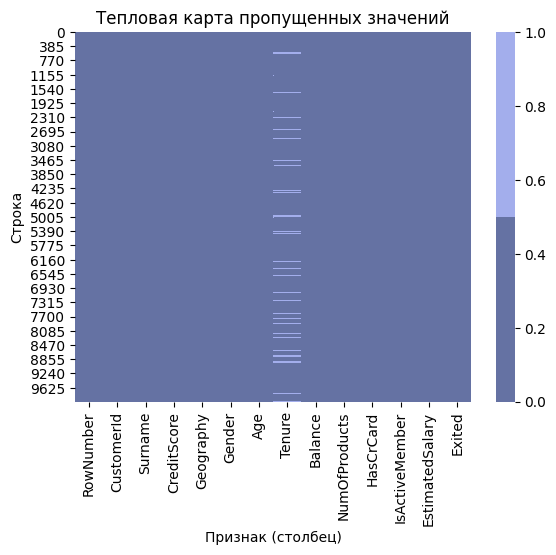

In [5]:
# построим тепловую карту пропущенных значений
sns.heatmap(data.isnull(), cmap=sns.color_palette(['#6572a3', '#a3aeec'] ))
plt.xlabel('Признак (столбец)')
plt.ylabel('Строка')
plt.title('Тепловая карта пропущенных значений')

In [6]:
# составим процентный список пропущенных данных
for col in data.columns:
    pct_missing = np.mean(data[col].isnull())
    print(f'{col} - {round(pct_missing*100)}%')
    
data['Tenure'].describe()

RowNumber - 0%
CustomerId - 0%
Surname - 0%
CreditScore - 0%
Geography - 0%
Gender - 0%
Age - 0%
Tenure - 9%
Balance - 0%
NumOfProducts - 0%
HasCrCard - 0%
IsActiveMember - 0%
EstimatedSalary - 0%
Exited - 0%


count    9091.000000
mean        4.997690
std         2.894723
min         0.000000
25%         2.000000
50%         5.000000
75%         7.000000
max        10.000000
Name: Tenure, dtype: float64

В столбце `Tenure` отсутствует 9% значений. Удалять пропущенные значения не будем. Среднее и медиана у этого признака почти одинаковые. Заполним пропуски медианным значением.

In [7]:
# заменим пропущенные значения столбца Tenure медианным значением
med = data['Tenure'].median()
display(med)
data['Tenure'] = data['Tenure'].fillna(med)

5.0

Признаки `Surname`, `RowNumber` и `CustomerId` являются нерелевантными для нашего проекта. Избавимся от них.

In [8]:
data = data.drop(['Surname', 'RowNumber', 'CustomerId'], axis=1)
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Применим прямое кодирование ко всему датафрейму.

In [9]:
data_ohe = pd.get_dummies(data, drop_first=True)

Разделим данные на признаки (features) и целевой признак (target).  
Целевым признаком будет факт ухода клиента - столбец `Exited`.  
Признаками будут все столбцы, кроме `Exited`.

In [10]:
features = data_ohe.drop('Exited', axis=1)
target = data_ohe['Exited']

In [11]:
RANDOM_STATE = 12345

In [12]:
# Разделим данные с признаками и целевым признаком на две выборки - обучающую и валидационную.
features_train, features_valid, target_train, target_valid = train_test_split(features, target,
                                                                              test_size=0.4, random_state=RANDOM_STATE)

In [13]:
# Разделим валидационне данные с признаками и целевым признаком на две выборки - валидационную и тестовую.
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, target_valid,
                                                                              test_size=0.5, random_state=RANDOM_STATE)

In [14]:
print('features_train: ', features_train.shape)
print('features_valid: ', features_valid.shape)
print('features_test:  ', features_test.shape)

features_train:  (6000, 11)
features_valid:  (2000, 11)
features_test:   (2000, 11)


Мы разделили данные в соотношении 60:20:20.  
В тренировочной выборке у нас получилось 6000 объектов, в валидационной и тестовой - по 2000 объектов

Теперь стандартизируем численные признаки.

In [15]:
features_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
7479,567,35,8.0,153137.74,1,1,0,88659.07,False,True,True
3411,711,37,8.0,113899.92,1,0,0,80215.20,False,False,False
6027,850,44,3.0,140393.65,2,0,1,186285.52,True,False,True
1247,512,24,6.0,0.00,2,1,0,37654.31,False,False,True
3716,665,27,2.0,147435.96,1,0,0,187508.06,True,False,False


In [16]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [17]:
pd.options.mode.chained_assignment = None # Чтобы не появялось предупреждение SettingWithCopy 
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

## Исследование задачи

Проверим соотношение отрицательных и положительных ответов

Exited
0    0.800667
1    0.199333
Name: proportion, dtype: float64


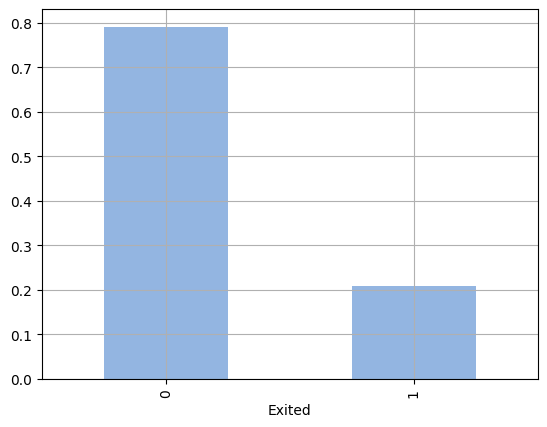

In [18]:
target_valid.value_counts(normalize=1).plot(kind ='bar', grid=True, color='#93b5e1')
print(target_train.value_counts(normalize=1))

В целевом признаке наблюдается дисбаланс классов, т.к. отрицательных ответов около 80%, а положительных около 20%.

### Проверим качество моделей без учета дисбаланса.

**Логистическая регрессия**

In [19]:
model = LogisticRegression(random_state=RANDOM_STATE, solver='liblinear')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print('Логистическая регрессия:\n')
metrics(target_valid, predicted_valid)

Логистическая регрессия:

Матрица ошибок:
 [[1506   76]
 [ 320   98]]
Полнота: 0.23444976076555024
Точность: 0.5632183908045977
F1-мера: 0.33108108108108103


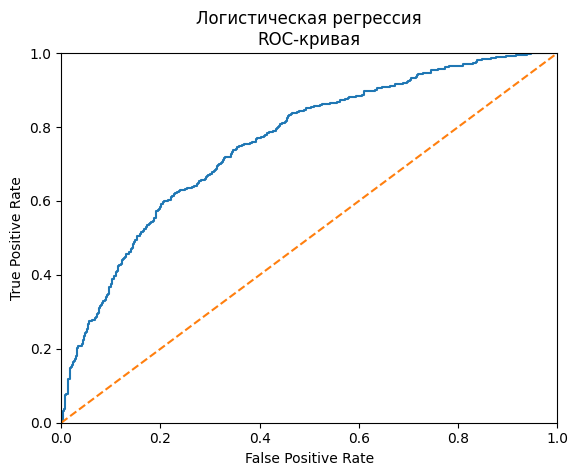

0.7587512627102753


In [20]:
auc_roc(features_valid, target_valid, model, 'Логистическая регрессия')

Модель `логистическая регрессия` почти всегда дает отрицательные ответы.

**Дерево решений**

In [21]:
best_result = 0
for i1 in range(1, 21):
    for i2 in range(1, 20, 2):
        for i3 in np.arange(2, 25, 2):
            model = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=i1,
                                           min_samples_leaf=i2, min_samples_split=i3)
            model.fit(features_train, target_train)
            predicted_valid = model.predict(features_valid)
            result = f1_score(target_valid, predicted_valid)
            if result > best_result:
                best_result = result
                best_max_depth = i1
                best_min_samples_leaf = i2
                best_min_samples_split = i3
                best_DTC = model

print('F1-мера наилучшей модели на валидационной выборке:', best_result,'\nЛучший max_depth:', best_max_depth,
     '\nЛучший min_samples_leaf:', best_min_samples_leaf, '\nЛучший min_samples_split:', best_min_samples_split)

F1-мера наилучшей модели на валидационной выборке: 0.577524893314367 
Лучший max_depth: 9 
Лучший min_samples_leaf: 1 
Лучший min_samples_split: 18


In [22]:
predicted_valid = best_DTC.predict(features_valid)
print('Дерево решений:\n')
metrics(target_valid, predicted_valid)

Дерево решений:

Матрица ошибок:
 [[1500   82]
 [ 215  203]]
Полнота: 0.48564593301435405
Точность: 0.712280701754386
F1-мера: 0.577524893314367


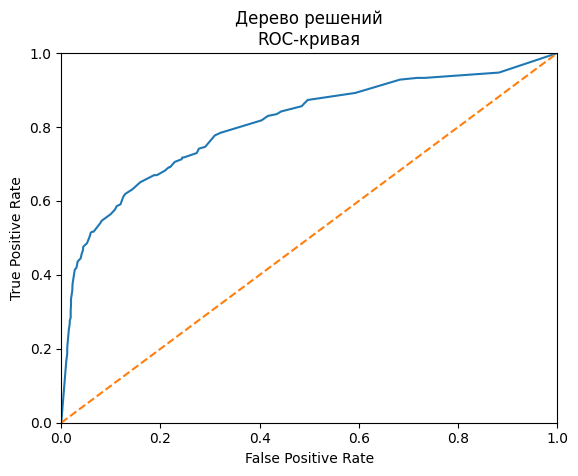

0.8073315831816064


In [23]:
auc_roc(features_valid, target_valid, best_DTC, 'Дерево решений')

`Дерево решений` показало лучший результат, чем `логическая регрессия`, но до идеала еще далеко.

**Случайный лес**

In [24]:
best_result = 0
for est in range(1, 50, 2):
    for depth in range(1, 21):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(features_train, target_train)
        predicted_valid = model.predict(features_valid)
        result = f1_score(target_valid, predicted_valid)
        if result > best_result:
            best_result = result
            best_n_estimators = est
            best_max_depth = depth
            best_RFC = model
print('Лучшие параметры для случайного леса', '\nn_estimators:', best_n_estimators, '\nmax_depth:', best_max_depth)

Лучшие параметры для случайного леса 
n_estimators: 9 
max_depth: 14


In [25]:
predicted_valid = best_RFC.predict(features_valid)
print('Случайный лес:\n')
metrics(target_valid, predicted_valid)

Случайный лес:

Матрица ошибок:
 [[1517   65]
 [ 211  207]]
Полнота: 0.49521531100478466
Точность: 0.7610294117647058
F1-мера: 0.5999999999999999


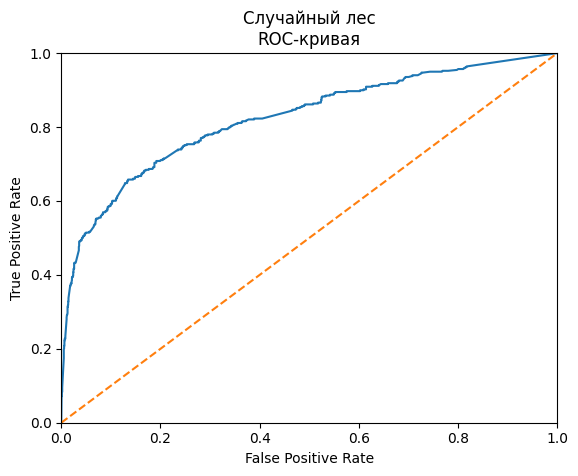

0.8222860046334661


In [26]:
auc_roc(features_valid, target_valid, best_RFC, 'Случайный лес')

`F1-мера` без учета дисбаланса :  
- у `логистической регресси`: 0.33108108108108103
- у `дерева решений`: 0.577524893314367
- у `случайного леса`: 0.5999999999999999

`AUC-ROC` без учета дисбаланса :  
- у `логистической регресси`: 0.7587512627102753 
- у `дерева решений`: 0.8073315831816064 
- у `случайного леса`: 0.8222860046334661

Наилучший результат показал `случайный лес` с гиперпараметрами:
- n_estimators: 9 
- max_depth: 14

## Борьба с дисбалансом

### Увеличение выборки

Как мы выяснили ранее, отрицательных ответов в нашей выборке в 4 раза больше, чем положительных (80% и 20%). Поэтому увеличим в 4 раза количество положительных ответов.

In [27]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

Exited
0    0.501043
1    0.498957
Name: proportion, dtype: float64


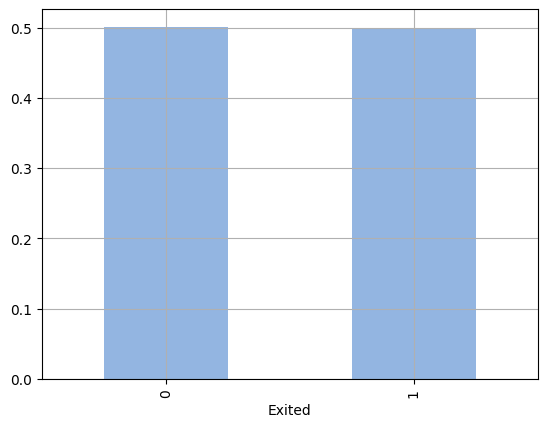

In [28]:
target_upsampled.value_counts(normalize=1).plot(kind ='bar', grid=True, color='#93b5e1')
print(target_upsampled.value_counts(normalize=1))

Теперь количество положительных и отрицательных ответов почти поровну:  
- 0: 0.501043
- 1: 0.498957  

Обучим наши модели с учетом дисбаланса и определим лучшую.

**Логистическая регрессия**

In [29]:
model = LogisticRegression(random_state=RANDOM_STATE, solver='liblinear')
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
print('Логистическая регрессия:\n')
metrics(target_valid, predicted_valid)

Логистическая регрессия:

Матрица ошибок:
 [[1119  463]
 [ 133  285]]
Полнота: 0.6818181818181818
Точность: 0.3810160427807487
F1-мера: 0.4888507718696398


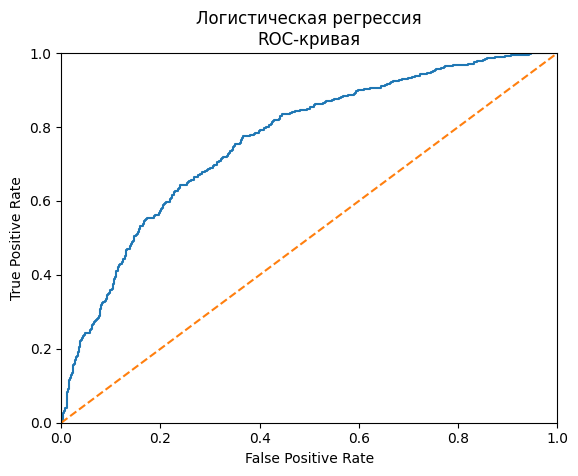

0.7636478565682107


In [30]:
auc_roc(features_valid, target_valid, model, 'Логистическая регрессия')

С учетом дисбаланса, модель `логистическая регрессия` стала предсказывать гораздо лучше. 

**Дерево решений**

In [70]:
best_result = 0
for i1 in range(1, 21):
    for i2 in range(19, 40, 1):
        for i3 in np.arange(2, 25, 2):
            model = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=i1,
                                           min_samples_leaf=i2, min_samples_split=i3)
            model.fit(features_upsampled, target_upsampled)
            predicted_valid = model.predict(features_valid)
            result = f1_score(target_valid, predicted_valid)
            if result > best_result:
                best_result = result
                best_max_depth = i1
                best_min_samples_leaf = i2
                best_min_samples_split = i3
                best_DTC_up = model

print('F1-мера наилучшей модели на валидационной выборке:', best_result,'\nЛучший max_depth:', best_max_depth,
     '\nЛучший min_samples_leaf:', best_min_samples_leaf, '\nЛучший min_samples_split:', best_min_samples_split)

F1-мера наилучшей модели на валидационной выборке: 0.6010471204188481 
Лучший max_depth: 5 
Лучший min_samples_leaf: 19 
Лучший min_samples_split: 2


~~F1-мера наилучшей модели на валидационной выборке: 0.6010471204188481   
Лучший max_depth: 5   
Лучший min_samples_leaf: 2   
Лучший min_samples_split: 42  ~~

In [32]:
predicted_valid = best_DTC_up.predict(features_valid)

In [33]:
metrics(target_valid, predicted_valid)

Матрица ошибок:
 [[1332  250]
 [ 131  287]]
Полнота: 0.6866028708133971
Точность: 0.5344506517690876
F1-мера: 0.6010471204188481


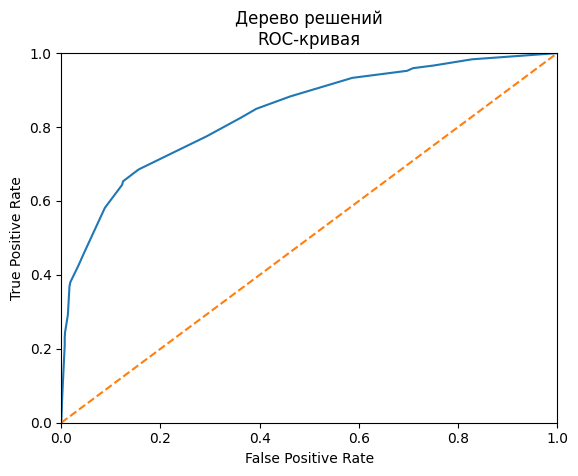

0.8368449784961197


In [34]:
auc_roc(features_valid, target_valid, best_DTC_up, 'Дерево решений')

Качество модели `дерево решений` с учетом дисбаланса тоже улучшилось.

**Случайный лес**

In [61]:
best_result = 0
for est in range(25, 301, 25):
    for depth in range(2, 50):
        model = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=est, max_depth=depth, n_jobs=-1)
        model.fit(features_upsampled, target_upsampled)
        predicted_valid = model.predict(features_valid)
        result = f1_score(target_valid, predicted_valid)
        if result > best_result:
            best_result = result
            best_n_estimators = est
            best_max_depth = depth
            best_RFC_up = model

print('F1-мера наилучшей модели на валидационной выборке:', best_result, '\nЛучший n_estimators:', best_n_estimators,
     '\nЛучший max_depth:', best_max_depth)

F1-мера наилучшей модели на валидационной выборке: 0.6275346851654217 
Лучший n_estimators: 100 
Лучший max_depth: 9


In [63]:
predicted_valid = best_RFC_up.predict(features_valid)

In [64]:
metrics(target_valid, predicted_valid)

Матрица ошибок:
 [[1357  225]
 [ 124  294]]
Полнота: 0.7033492822966507
Точность: 0.5664739884393064
F1-мера: 0.6275346851654217


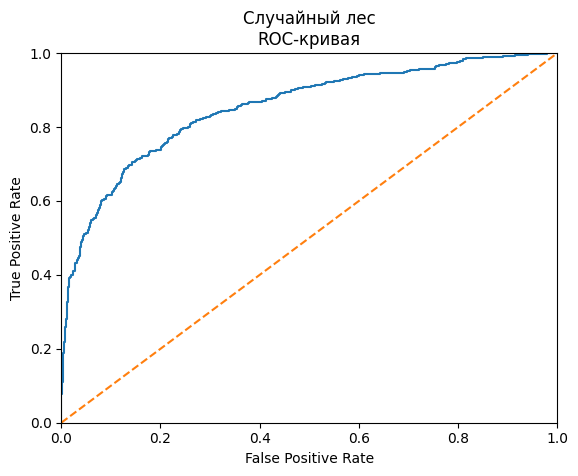

0.8526772482291812


In [66]:
auc_roc(features_valid, target_valid, best_RFC_up, 'Случайный лес')

Качество модели `случайный лес`, как и у предыдущих моделей, с учетом дисбаланса, заметно улучшилось.

**На увеличенной выборке**  

F1-мера с учетом дисбаланса:  
- у логистической регресси: 0.4888507718696398
- у дерева решений: 0.6010471204188481  
- у случайного леса: 0.6275346851654217 

AUC-ROC с учетом дисбаланса:  
- у логистической регресси: 0.7636478565682107
- у дерева решений: 0.8368449784961197
- у случайного леса: 0.8526772482291812  

Лучшей моделью стал `случайный лес` с гиперпараметрами:
- n_estimators: 100 
- max_depth: 9

### Уменьшение выборки

Exited
0    0.501043
1    0.498957
Name: proportion, dtype: float64


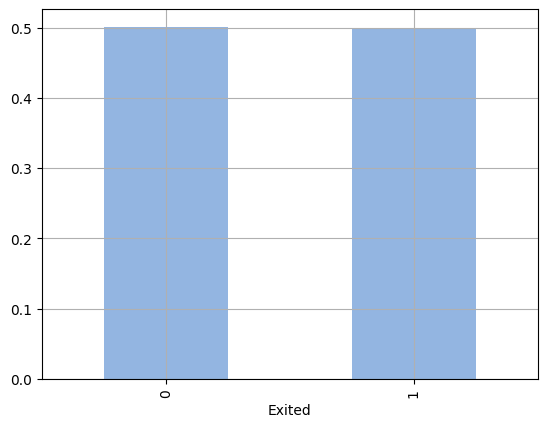

In [39]:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)
target_downsampled.value_counts(normalize=1).plot(kind ='bar', grid=True, color='#93b5e1')
print(target_downsampled.value_counts(normalize=1))

In [40]:
model = LogisticRegression(random_state=RANDOM_STATE, solver='liblinear')
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
print('Логистическая регрессия:\n')
metrics(target_valid, predicted_valid)

Логистическая регрессия:

Матрица ошибок:
 [[1120  462]
 [ 137  281]]
Полнота: 0.6722488038277512
Точность: 0.3781965006729475
F1-мера: 0.48406546080964685


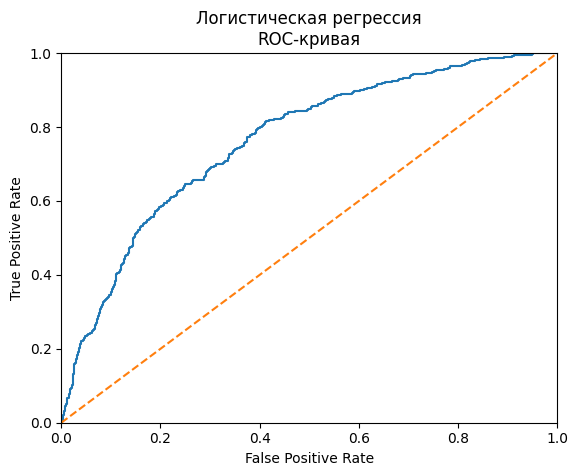

0.7622883637089505


In [41]:
auc_roc(features_valid, target_valid, model, 'Логистическая регрессия')

**Дерево решений**

In [42]:
best_result = 0
for i1 in range(1, 21):
    for i2 in range(1, 20, 2):
        for i3 in np.arange(2, 25, 2):
            model = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=i1,
                                           min_samples_leaf=i2, min_samples_split=i3)
            model.fit(features_downsampled, target_downsampled)
            predicted_valid = model.predict(features_valid)
            result = f1_score(target_valid, predicted_valid)
            if result > best_result:
                best_result = result
                best_max_depth = i1
                best_min_samples_leaf = i2
                best_min_samples_split = i3
                best_DTC_down = model

print('F1-мера наилучшей модели на валидационной выборке:', best_result,'\nЛучший max_depth:', best_max_depth,
     '\nЛучший min_samples_leaf:', best_min_samples_leaf, '\nЛучший min_samples_split:', best_min_samples_split)

F1-мера наилучшей модели на валидационной выборке: 0.5995934959349594 
Лучший max_depth: 5 
Лучший min_samples_leaf: 3 
Лучший min_samples_split: 18


~~F1-мера наилучшей модели на валидационной выборке: 0.5995934959349594   
Лучший max_depth: 5   
Лучший min_samples_leaf: 3   
Лучший min_samples_split: 17  ~~

In [43]:
predicted_valid = best_DTC_down.predict(features_valid)

In [44]:
metrics(target_valid, predicted_valid)

Матрица ошибок:
 [[1311  271]
 [ 123  295]]
Полнота: 0.7057416267942583
Точность: 0.5212014134275619
F1-мера: 0.5995934959349594


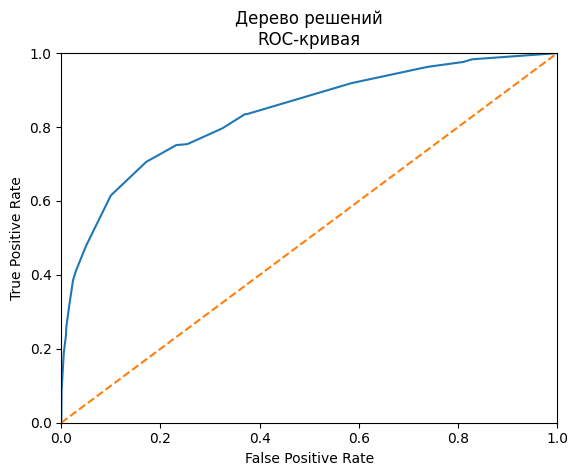

0.834765665168553


In [45]:
auc_roc(features_valid, target_valid, best_DTC_down, 'Дерево решений')

**Случайный лес**

In [57]:
best_result = 0
for est in range(100, 501, 50):
    for depth in range(2, 25):
        model = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=est, max_depth=depth, n_jobs=-1)
        model.fit(features_downsampled, target_downsampled)
        predicted_valid = model.predict(features_valid)
        result = f1_score(target_valid, predicted_valid)
        if result > best_result:
            best_result = result
            best_n_estimators = est
            best_max_depth = depth
            best_RFC_down = model

print('F1-мера наилучшей модели на валидационной выборке:', best_result, '\nЛучший n_estimators:', best_n_estimators,
     '\nЛучший max_depth:', best_max_depth)

F1-мера наилучшей модели на валидационной выборке: 0.6072796934865899 
Лучший n_estimators: 100 
Лучший max_depth: 8


In [58]:
predicted_valid = best_RFC_down.predict(features_valid)

In [59]:
metrics(target_valid, predicted_valid)

Матрица ошибок:
 [[1273  309]
 [ 101  317]]
Полнота: 0.7583732057416268
Точность: 0.5063897763578274
F1-мера: 0.6072796934865899


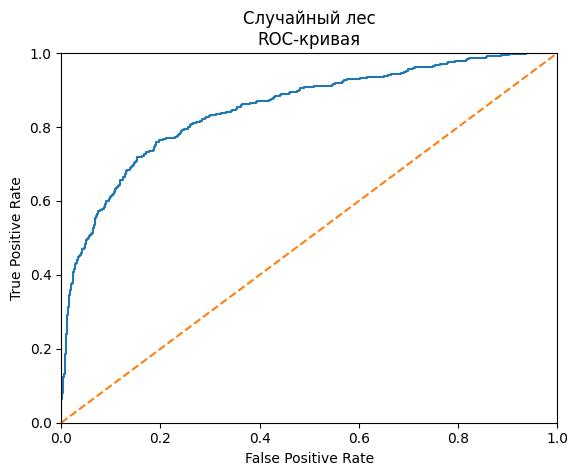

0.8496709392144883


In [60]:
auc_roc(features_valid, target_valid, best_RFC_down, 'Случайный лес')

**На уменьшенной выборке**  

`F1-мера` с учетом дисбаланса:
- у `логистической регресси`: 0.48406546080964685
- у `дерева решений`: 0.5995934959349594
- у `случайного леса`: 0.6072796934865899  

`AUC-ROC` с учетом дисбаланса:
- у `логистической регресси`: 0.7622883637089505
- у `дерева решений`: 0.834765665168553
- у `случайного леса`: 0.8496709392144883

**На увеличенной выборке результат оказался лучше**

## Тестирование модели

Проверим нашу лучшую модель на тестовой выборке.  
Модель: `Случайный лес`  
Гиперпараметры модели:
- n_estimators: 25
- max_depth: 8  

Метод борьбы с дисбалансом: `Увеличение выборки`

In [67]:
predicted_test = best_RFC_up.predict(features_test)
metrics(target_test, predicted_test)

Матрица ошибок:
 [[1329  248]
 [ 128  295]]
Полнота: 0.6973995271867612
Точность: 0.5432780847145487
F1-мера: 0.6107660455486542


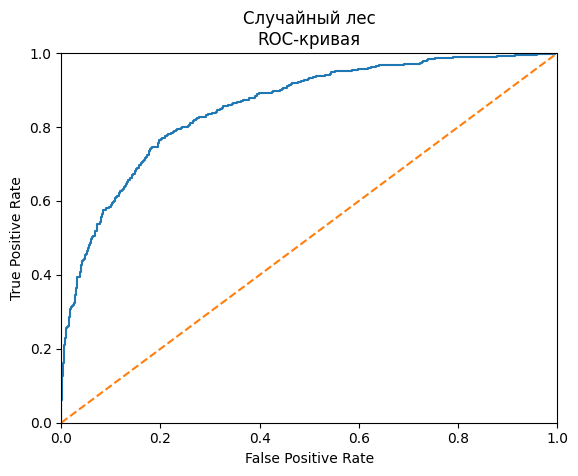

0.8556960203636494


In [68]:
auc_roc(features_test, target_test, best_RFC_up, 'Случайный лес')

На тестовой выборке `случайный лес` показал хороший результат:
- `F1-мера`: 0.6107660455486542
- `AUC-ROC`: 0.8556960203636494

Цель достигнута, `F1-мера` на тестовой выборке больше 0.59.

## Общий вывод  
1. Мы изучили предоставленный нам файл `Churn.csv`. Файл содержит 10000 объектов и состоит из 14 толбцов:  
    - `RowNumber` — индекс строки в данных
    - `CustomerId` — уникальный идентификатор клиента
    - `Surname` — фамилия
    - `CreditScore` — кредитный рейтинг
    - `Geography` — страна проживания
    - `Gender` — пол
    - `Age` — возраст
    - `Tenure` — сколько лет человек является клиентом банка
    - `Balance` — баланс на счёте
    - `NumOfProducts` — количество продуктов банка, используемых клиентом
    - `HasCrCard` — наличие кредитной карты
    - `IsActiveMember` — активность клиента
    - `EstimatedSalary` — предполагаемая зарплата
    - `Exited` — факт ухода клиента   
2. Выяснили, что в столбце `Tenure` отсутствует 9% значений. Удалять мы их не стали, а заменили медианным значением (`5`).  
3. Избавились от нерелевантных для нашего проекта признаков: `Surname`, `RowNumber` и `CustomerId`.  
4. Применили прямое кодирование ко всему датафрейму.  
5. Разделили данные на признаки (features) и целевой признак (target):
    - целевой признак - столбец `Exited`
    - признаки - все столбцы, кроме `Exited`  
6. Разделили исходные данные на обучающую, валидационную и тестовую выборки в соотношении 60:20:20.  
В тренировочной выборке у нас получилось 6000 объектов, в валидационной и тестовой - по 2000 объектов.   
7. Стандартизировали численные признаки `CreditScore`, `Age`, `Tenure`, `NumOfProducts` и `EstimatedSalary` во всех выборках.  
8. Выяснили, что в целевом признаке наблюдается дисбаланс классов:  
    - отрицательных ответов около 80%
    - положительных ответов около 20%.
9. Проверили качество моделей `логистическая регрессия`, `дерево решений` и `случайный лес`.  
В ходе проверки выяснили, что наилучший результат показала модель `случайный лес`:  
    `F1-мера` без учета дисбаланса :  
    - у `логистической регресси`: 0.023529411764705882  
    - у `дерева решений`: 0.5006045949214026  
    - у `случайного леса`: 0.5769805680119582  

    `AUC-ROC` без учета дисбаланса :  
    - у `логистической регресси`: 0.45469970178866315  
    - у `дерева решений`: 0.6837644190927842  
    - у `случайного леса`: 0.840733672475638  
10. Для борьбы с дисбалансом увеличили количество положительных ответов в 4 раза. Количество отрицательных и положительных ответов почти сравнялось: 
    - 0: 0.501043
    - 1: 0.498957  
11. Обучили наши модели с учетом дисбаланса. Качество всех моделей стало заметно лучше:
    F1-мера с учетом дисбаланса:  
    - у логистической регресси: 0.40257648953301123 
    - у дерева решений: 0.6010471204188481  
    - у случайного леса: 0.6275346851654217  

    AUC-ROC с учетом дисбаланса:  
    - у логистической регресси: 0.5960506656827104  
    - у дерева решений: 0.8367353419752117  
    - у случайного леса: 0.8526772482291812 

    Лучшей моделью стал `случайный лес` с гиперпараметрами:
    - Лучший n_estimators: 100 
    - Лучший max_depth: 9 

12. Рассмотрели 2 способа брьбы с дисбалансом:
    - увеличение выборки (редких классов)
    - уменьшение выборки (частых классов)  
    
    На увеличенной выборке результат оказался лучше.  
13. Проверили лучшую модель (`случайный лес`) на тестовой выборке. Результат оказался хорошим:
    - `F1-мера`: 0.6107660455486542
    - `AUC-ROC`: 0.8556960203636494

14. Цель достигнута, `F1-мера` на тестовой выборке больше 0.59.

In [52]:
target_pred_constant = pd.Series([1] * len(target_test))
print('\033[1mКонстантная модель:\n\033[0m')
metrics(target_test, target_pred_constant)

Константная модель:

Матрица ошибок:
 [[   0 1577]
 [   0  423]]
Полнота: 1.0
Точность: 0.2115
F1-мера: 0.3491539413949649


In [53]:
dummy_model = DummyClassifier(strategy='constant', constant=1)
dummy_model.fit(features_train, target_train)
predicted_const = dummy_model.predict(features_test)
print('\033[1mКонстантная модель:\n\033[0m')
metrics(target_test, predicted_const)

Константная модель:

Матрица ошибок:
 [[   0 1577]
 [   0  423]]
Полнота: 1.0
Точность: 0.2115
F1-мера: 0.3491539413949649


<div class="alert alert-info">
F1-мера константной модели: 0.3491539413949649  
    
F1-мера нашей модели: 0.6107660455486542  
    
F1-мера нашей модели почти в два раза выше, чем константной. Полнота (recall) нашей модели равна 0.706855791962175. Это значит, что 70% клиентов, собирающихся расторгнуть договор с банком, наша модель определит верно.  
    
Исходя из всего вышесказанного, мы можем смело сказать - заказчик останется доволен, модель справилась с поставленной задачей.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: задача исследована
    - [x]  Исследован баланс классов
    - [x]  Изучены модели без учёта дисбаланса
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 3: учтён дисбаланс
    - [x]  Применено несколько способов борьбы с дисбалансом
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 4: проведено тестирование
- [x]  Удалось достичь *F1*-меры не менее 0.59
- [x]  Исследована метрика *AUC-ROC*

https://github.com/AleksandrPortnov/learning_with_a_teacher.git